# Breast Cancer Detection using Machine Learning

## 1. data anaylysis

In [162]:
import os
import glob
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle




from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import cv2


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator




In [127]:
IMG_HEIGHT = 480
IMG_WIDTH = 480

In [193]:
TRAIN_CSV = "./data/train/feats.csv"
TRAIN_IMG_DIR = "./data/train/images"

TEST_CSV = "./data/test/feats.csv"
TEST_IMG_DIR = "./data/test/images"

CLEAN_DATA_FILE = "./data/train/cleaned_data.csv"
MODEL_PATH = "./model"

In [68]:
train_df = pd.read_csv(TRAIN_CSV)
print("train record:\n", train_df.head())
print("train record shape: ", train_df.shape)




train record:
                                                   id  age  HER2    P53  \
0  8a1af6f74cafc720511888998f2f361767c77965a07464...   48     3   True   
1  b18adad8c39bb458f208581fe40e9be7b04f2b49be04b0...   54     3  False   
2  8b9af020d0e621168fd0f3913f2cd74e8bb5ea85f61ee0...   55     2   True   
3  1a0e54f07794fbb95a0fd7f0b4ef6f79ef1a9c83dbaa05...   66     0  False   
4  2805706a656b013743d84357d5ffa44536e19d18f0509f...   31     0  False   

   molecular_subtype  
0                  3  
1                  2  
2                  3  
3                  4  
4                  1  
train record shape:  (200, 5)


In [69]:
test_df = pd.read_csv(TEST_CSV)
print("test record:\n", test_df.tail())
test_df.shape

test record:
                                                    id  age  HER2    P53
82  0de3f1bf4ccc440271f091d79e9d3be7348dd5a39d7657...   66     3  False
83  46aaa33f2f3c07741ca4aeea4c9f3e54e23d86ee8e4fd6...   50     0  False
84  2eaae4e8b29e28877112cfdc0257b93218d97cdbfb6670...   53     3  False
85  7a1725339e56e7a9cff48bb5af4ea84f731996a88a4422...   46     0  False
86  d59d78555b3a4f3175c5f2183ffc214eb06a4573289cb2...   48     1  False


(87, 4)

(514, 760)


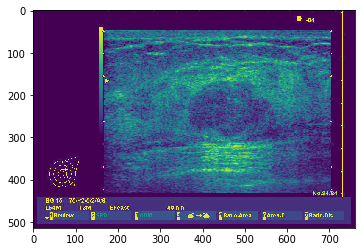

In [52]:
img = Image.open(os.path.join(TRAIN_IMG_DIR, train_df.iloc[100, 0], "1.jpg"))
plt.imshow(img)

print(np.asarray(img).shape)

## 2. data preprocessing

In [122]:
## covert label to onehot encoding
raw_train_label = list(train_df["molecular_subtype"])
raw_train_label = np.asarray(raw_train_label).reshape(-1, 1)
#print(raw_train_label)
enc = OneHotEncoder(sparse=False)
enc.fit(raw_train_label)
train_label = enc.transform(raw_train_label)

#for raw, transformed in zip(raw_train_label, train_label):
#    print(raw, transformed)
    

In [135]:
f = open(CLEAN_DATA_FILE, "w")
for idx, row in train_df.iterrows():
    #print(idx, row["id"], row["molecular_subtype"], enc.transform(np.asarray(row["molecular_subtype"]).reshape(-1, 1)))
    images = glob.glob(os.path.join(TRAIN_IMG_DIR, row["id"], "*.*"))
    label = np.squeeze(enc.transform(np.asarray(row["molecular_subtype"]).reshape(-1, 1)))
    for image in images:
        #print(idx, image, label)
        f.write(f'{image}, {row["molecular_subtype"]}\n')

f.close()

In [116]:
print(dir(tf.keras.applications))
#'''
base_model = tf.keras.applications.ResNet50(input_shape=(480, 480, 3),
                                               include_top=False,
                                               weights='imagenet')
                                               #'''

['DenseNet121', 'DenseNet169', 'DenseNet201', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_sys', 'densenet', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 'xception']
94773248/94765736 [==============================] - 827s 9us/step


## 2. build machine learning model 

In [190]:
def build_model():
    model = Sequential()
    model.add(Conv2D(16, 1, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,1)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(4))
    
    
    model.summary()
    return model

build_model()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 480, 480, 16)      32        
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 240, 240, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 240, 240, 32)      4640      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 120, 120, 64)      18496     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 60, 60, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 230400)          

## prepare training data

In [218]:
train_image = []
train_raw_label = []
with open(CLEAN_DATA_FILE, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split(",")
        #print(temp[0], temp[1].strip())
        train_image.append(temp[0])
        train_raw_label.append(temp[1].strip())


train_image = np.asarray(train_image)
train_raw_label = np.asarray(train_raw_label).reshape(-1, 1)
#print(len(train_image), len(train_raw_label))
encoder = OneHotEncoder(sparse=False)
train_label = encoder.fit_transform(train_raw_label)

train_image, train_label = shuffle(train_image, train_label)
print(train_image.shape, train_label.shape)

print(train_label)

(925,) (925, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [169]:
for k in train_image:
    img = cv2.imread(k, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = np.asarray(img, dtype=float)
    #print(img.shape)
    #plt.imshow(img) 
    #plt.show()
    #input()
  
  
    

In [212]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = np.asarray(image)
    image = image /255.0 
    #print(image.shape)
    return image

train_X = []
for img in train_image:
    train_X.append(preprocess_image(img))

train_X = np.asarray(train_X)
train_X = train_X.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
print(train_X.shape)

(925, 480, 480, 1)


In [213]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(train_X)


In [230]:
model = build_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit_generator(datagen.flow(train_X, train_label, batch_size=32),
                    #steps_per_epoch=len(train_X) / 32, epochs=10)
                    steps_per_epoch=1, epochs=10)

model.save(os.path.join(MODEL_PATH, "saved_model.h5"))

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 480, 480, 16)      32        
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 240, 240, 16)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 240, 240, 32)      4640      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 120, 120, 64)      18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 60, 60, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 230400)          

[[  4.2841315  34.27569    -7.3189387 -19.31627  ]] 1


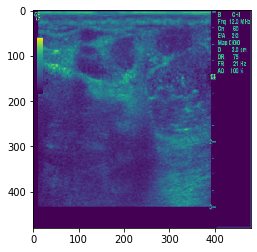

In [221]:
test_image = preprocess_image(train_image[2])
plt.imshow(test_image)
test_image = np.expand_dims(test_image, axis=2)  
result = model.predict(np.asarray([test_image]))

print(result, np.argmax(result))

In [234]:
def predict(model, image_path):
    image = preprocess_image(image_path)
    test_image = np.expand_dims(image, axis=2)  
    prediction =  model.predict(np.asarray([test_image]))
    result = np.argmax(prediction) + 1
    return result

IDX = 123
y_pred = predict(model, train_image[2])
print(f"index: {IDX}, predction: {y_pred}, truth: {train_raw_label[IDX]}")    

index: 123, predction: 3, truth: ['2']


In [239]:
def create_result(csv_path):
    test_df = pd.read_csv(csv_path)
    